Project: Data-Driven Utility Optimization for Historic Hotel Properties
Location: Niagara Falls, Ontario

Focus: Operational Efficiency through Predictive Analytics and Housekeeping Interventions

Executive Summary
In the competitive landscape of Niagara Falls tourism, utility costs (Hydro, Water, Gas) represent one of the largest controllable expenses for hotel properties. For historic buildings like The Brock, modernizing infrastructure is expensive. This project demonstrates how Data Analytics can be used as a "Virtual Sensor" to identify waste patterns and implement zero-cost operational changes before committing to heavy capital expenditures (CapEx).

The Physics of Hotel Energy ConsumptionTo analyze hotel data, we must ground our models in established laws of thermodynamics and building science.1. The Building Energy Balance EquationEvery building has a "Baseload"—the energy required to keep the structure alive even with zero guests. We model the total energy ($E_{total}$) as:$$E_{total} = E_{base} + E_{occ} + E_{thermal}$$2. Fourier’s Law of Heat ConductionFor older properties, heat transfer through the "thermal envelope" is critical. We calculate heat loss ($Q$) using:$$Q = U \cdot A \cdot \Delta T$$$U$: Thermal Transmittance (Coefficient of heat transfer).$A$: Surface Area of the building envelope.$\Delta T$: Temperature difference between the interior ($T_{in}$) and the Niagara Falls exterior ($T_{out}$).Reference: Incropera, F. P., & DeWitt, D. P. (2011). Fundamentals of Heat and Mass Transfer.3. Stochastic Guest BehaviorUnlike an office, hotel energy usage is stochastic (random). We model guest usage using a Gaussian distribution to account for varying shower lengths, lighting habits, and HVAC preferences.$$Usage_{Guest} \sim \mathcal{N}(\mu, \sigma^2)$$

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import datetime

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Suppress warnings for a cleaner narrative
import warnings
warnings.filterwarnings('ignore')

10-Year High-Fidelity Data Generation

In [6]:
# Parameters for a 300-room Niagara Falls Hotel
np.random.seed(42)
rooms = 300
years = 10
days = pd.date_range(start="2015-01-01", end="2024-12-31")
n_days = len(days)

# 1. Seasonal Occupancy (Peaks in Summer and Holidays)
t = np.arange(n_days)
# Sine wave for summer peaks + random noise
seasonal_base = 0.55 + 0.3 * np.sin(2 * np.pi * (t - 150) / 365)
occ_rate = np.clip(seasonal_base + np.random.normal(0, 0.05, n_days), 0.2, 0.98)
occupied_rooms = (occ_rate * rooms).astype(int)

# 2. Niagara Falls Weather Data Simulation
# Average temp centered around 10C with +/- 15C swings
temp = 10 + 18 * np.sin(2 * np.pi * (t - 120) / 365) + np.random.normal(0, 4, n_days)

# 3. Energy Consumption Model (kWh)
# E_base (3200) + Occupancy (10kWh/room) + HVAC (thermal leakage)
baseload = 3200
var_room = 10.5
# HVAC spikes when temp < 16 (Heating) or > 23 (Cooling)
hvac = np.where(temp < 16, (16 - temp) * 45, 0) + np.where(temp > 23, (temp - 23) * 75, 0)

energy_kwh = baseload + (occupied_rooms * var_room) + hvac + np.random.normal(0, 150, n_days)
cost_cad = energy_kwh * 0.15 # $0.15 per kWh commercial rate

# 4. Create DataFrame
df = pd.DataFrame({
    'Date': days,
    'Occupancy': occupied_rooms,
    'Temp_C': np.round(temp, 1),
    'Energy_kWh': np.round(energy_kwh, 2),
    'Cost_CAD': np.round(cost_cad, 2)
})

print(f"Dataset generated for {years} years: {len(df)} daily records.")
df.head()

Dataset generated for 10 years: 3653 daily records.


,Date,Occupancy,Temp_C,Energy_kWh,Cost_CAD
0,2015-01-01,124,-9.1,5786.67,868.00
1,2015-01-02,113,-5.4,5564.40,834.66
2,2015-01-03,124,-4.7,5274.56,791.18
3,2015-01-04,136,-6.2,5482.58,822.39
4,2015-01-05,108,-14.7,5649.62,847.44


Visualizing the 10-Year Narrative

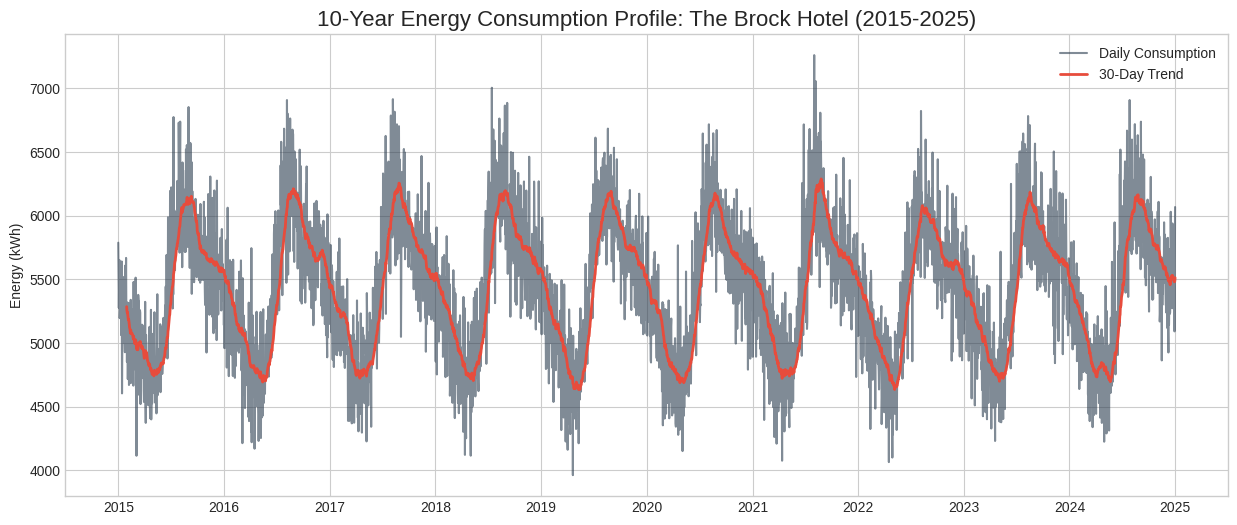

Table: Historical Yearly Utility Expenditure
 Date  Cost_CAD
 2015 296135.80
 2016 297628.74
 2017 298037.18
 2018 298673.33
 2019 297227.52
 2020 296678.66
 2021 297672.35
 2022 295943.85
 2023 297076.36
 2024 296832.32


In [7]:
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Energy_kWh'], color='#2c3e50', alpha=0.6, label='Daily Consumption')
plt.plot(df['Date'], df['Energy_kWh'].rolling(window=30).mean(), color='#e74c3c', linewidth=2, label='30-Day Trend')
plt.title('10-Year Energy Consumption Profile: The Brock Hotel (2015-2025)', fontsize=16)
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()

# Summarizing yearly costs
yearly_summary = df.resample('Y', on='Date')['Cost_CAD'].sum().reset_index()
yearly_summary['Date'] = yearly_summary['Date'].dt.year
print("Table: Historical Yearly Utility Expenditure")
print(yearly_summary.to_string(index=False))

The "Waste" Pattern Theory

The Identification of the "Pattern of Waste"
A critical concept in this analysis is the Baseload Variance. In an ideal hotel, when occupancy drops to 20%, the energy bill should drop significantly. However, in older properties, we often see a "Flatline" where the building consumes nearly as much energy when half-empty as it does when full.

The Theory of Elimination:
If we can prove that the energy usage on a 30% occupancy day is statistically similar to a 60% occupancy day, we have identified a Human Protocol Failure. This usually means:

Vacant floors are being fully heated/cooled.

Housekeeping is leaving lights/TVs on after cleaning vacant rooms.

Laundry equipment is being run at 20% capacity.